In [1]:
import numpy as np
from dataframe import Data
from SNANA_FITS_to_pd import read_fits
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from io_utils import *
from random import random
from filter import transient_filter
from filter import transient_filter_load_saved

In [2]:
use_filter = False

In [3]:
dataset_val =1

In [4]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}
    bands = [0,1,2,3,4,5]
    transient_filter_load_saved(data_ob=data_ob)
    #bands = [0,1,2,3,4,5]
    
if dataset_val == 1:    
    dataset = "ZTF"
    #data_ob = load_ztf_data()
    data_ob = load_ztf_mixed()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids = object_ids
    bands = [b'g ', b'r ']
    color_band_dict = {b'g ':'C2', b'r ':'C3'}
    #transient_filter(data_ob=data_ob)

['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
------------------------------
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
------------------------------
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'SKY_SIG', 'ZEROPT', 'SIM_MAGOBS', 'SNID']
['MJD', 'FLT', 'FIELD', 'PHOTFLAG', 'PHOTP

In [5]:
#filter_result = transient_filter(data_ob)
#print(filter_result)

In [6]:
#np.save("filter_result",filter_result)

In [7]:
if use_filter:
    transient_filter_load_saved(data_ob=data_ob)
    filter_result = np.load("filter_result.npy")
    coeff_dict_list = np.load("coeff_arrays/coeff_dict_filtered.npy")
else:    
    coeff_dict_list = np.load("coeff_arrays/ZTF_coeff.npy")

In [8]:
print(coeff_dict_list)

[{b'g ': [1486.7651579883554, -330.12682361544046, -497.97045625809636], b'r ': [1621.852521075608, -305.81580751343296, -538.9909815862563]}
 {b'g ': [1348.3427588508964, -318.55962254226625, -660.5360373639987], b'r ': [1720.82784951566, 245.79654387412168, -288.542854465158]}
 {b'g ': [1401.334123501439, -814.646651345651, -233.10116284264154], b'r ': [1734.4286116406086, 4.7473232761585455, -165.6004715668793]}
 ...
 {b'g ': [5189.237984152967, -2533.454792835359, 1419.4585175597338], b'r ': [8826.798901232965, -1448.4097086210866, 2776.8416434384276]}
 {b'g ': [0, 0, 0], b'r ': [0, 0, 0]}
 {b'g ': [4034.3183194990024, -848.4296978938297, 809.564844824421], b'r ': [0, 0, 0]}]


In [9]:
from LightCurve import LightCurve

In [34]:
def get_kilonova_loc(object_list):
    kn_index=np.zeros(len(object_list), dtype = bool)
    for i,object_id in enumerate(object_list):
        if (data_ob.get_object_type_number(object_id)==50)|(data_ob.get_object_type_number(object_id)==51):
            kn_index[i] =True
    return kn_index

In [66]:
def plot_dict_data(coeff_plot_data, num_PC_components =3, color_band_dict=None, bands=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= False, mark_ylabel= False, set_ax_title=False, label=""):
    
    if fig is None:
        fig,axs = plt.subplots(len(bands),num_PC_components, figsize=(num_PC_components*5, len(bands)*5))
        fig.subplots_adjust(wspace=.5,hspace=.5)
        ax_list = fig.axes
    else:
        ax_list = fig.axes
    
    if bands is None:
        bands = data_ob.band_map.keys()
        
    for i,band in enumerate(bands):
        for x in range(num_PC_components):
            ax_current = ax_list[i*num_PC_components + x]
            if x==num_PC_components-1:
                y=0
            else:
                y = x+1
            
            coeff_band_data = np.asarray(coeff_plot_data[band])
            #print(coeff_plot_data)
            PCx = coeff_band_data[:,x]
            PCy = coeff_band_data[:,y]

            if color_band_dict is not None:
                ax_current.scatter(PCx,PCy, color = color_band_dict[band], alpha=.5, label=label)
            else:
                ax_current.scatter(PCx, PCy, color = "yellow", alpha=.4, label = label)
            
            if x_limits is not None: ax_current.set_xlim(x_limits)
            if y_limits is not None: ax_current.set_ylim(y_limits)
            if mark_xlabel: ax_current.set_xlabel("PC"+str(x+1))
            if mark_ylabel: ax_current.set_ylabel("PC"+str(y+1))  
            if set_ax_title: ax_current.set_title("PCs for "+ data_ob.band_map[band]+"-band")
            if label != "":
                ax_current.legend(loc="upper right")
    
    return fig

In [67]:
def create_plot_data(coeff_dict_list,band = None):
    plot_data={}

    if band is None:
        bands = data_ob.band_map.keys()
        
    for band in bands:
        plot_data[band] = []

    for coeff_dict_item in coeff_dict_list:
        
        for band in bands:
            #if np.sum(coeff_dict==0)!=3:
            #print(coeff_dict_item[band])
            plot_data[band].append(coeff_dict_item[band])
            
    #print(plot_data[0])
    #print(plot_data)
    return plot_data


In [68]:
def plt_PLAsTiCC_coeff(object_ids, coeff_dict_list, color_band_dict, num_PC_components=3, x_limits =None, y_limits=None, bands = None):
    
    if bands is None:
        bands = data_ob.band_map.keys()
    
    kn_index = get_kilonova_loc(object_ids)
    #kn_index = np.ones((248),dtype=bool)
    kn_ids = object_ids[kn_index]
    non_kn_ids = object_ids[~kn_index]
    #print(len(kn_index))
    #print(coeff_dict_list[7847])
    coeff_kn_dict_list = coeff_dict_list[kn_index]
    coeff_non_kn_dict_list = coeff_dict_list[~kn_index]
    
    fig,ax = plt.subplots(len(bands),num_PC_components, figsize=(num_PC_components*5, len(bands)*5))
    fig.subplots_adjust(wspace=.4,hspace=.4)
    if np.sum(len(~kn_index)>0):
        non_kn_plot_data = create_plot_data(coeff_non_kn_dict_list)
        fig = plot_dict_data(non_kn_plot_data, fig = fig, bands= bands, num_PC_components=num_PC_components, label = "non-KN")
    
    if np.sum(len(kn_index))>0:
        kn_plot_data = create_plot_data(coeff_kn_dict_list)
        fig = plot_dict_data(kn_plot_data, color_band_dict=color_band_dict, fig=fig, bands = bands, num_PC_components=num_PC_components, x_limits = x_limits, y_limits =y_limits, mark_xlabel = True, mark_ylabel= True, set_ax_title=True, label="KN")
        #fig = plot_dict_data(kn_plot_data, color_band_dict=color_band_dict, fig=fig, bands = bands, num_PC_components=num_PC_components, mark_xlabel = True, mark_ylabel= True, set_ax_title=True)
        
    #print(len(coeff_kn_dict_list))

    plt.show()

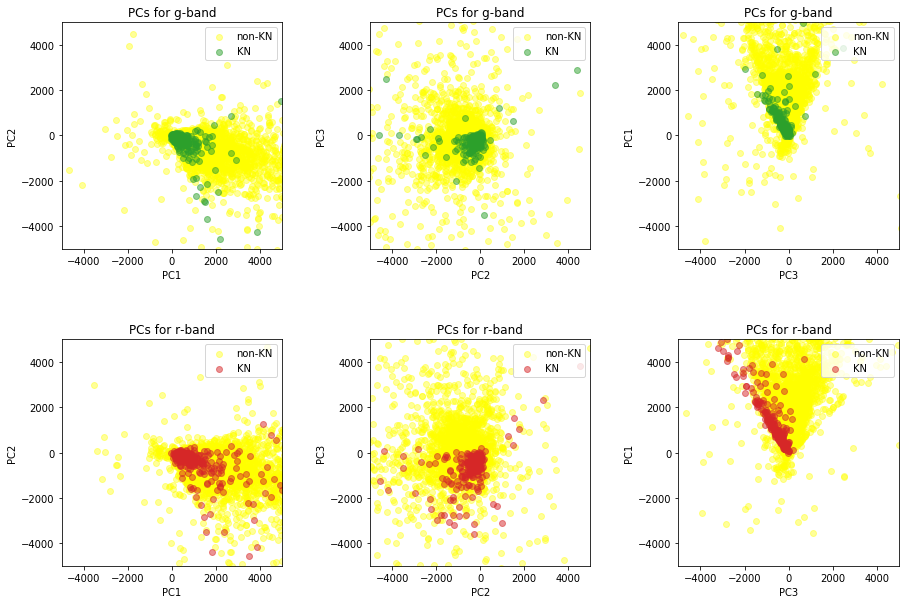

In [69]:
if use_filter:
    object_ids = data_ob.df_metadata[data_ob.object_id_col_name][data_ob.df_metadata['filter_result']]
#print(len(object_ids))

#print(len(coeff_dict_list))
plt_PLAsTiCC_coeff(object_ids = object_ids, coeff_dict_list=coeff_dict_list, color_band_dict=color_band_dict, x_limits=(-5000,5000),y_limits=(-5000,5000))

In [15]:
print(object_ids)

   SNID  
---------
117077604
 12378661
 59391402
 21768379
108467010
100532709
 38618553
 42014414
 42737856
 70945533
      ...
103108306
 99595725
 16916764
 97741148
 53044809
 85701848
 91653004
119163520
  1186507
121655544
 72803330
Length = 5047 rows
